In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import math
import matplotlib.pyplot as plt
import random

In [3]:
csv_path = '../all_data_two_date_gps_vi_savi_filter_0.9.csv'
df = pd.read_csv(csv_path)

test_pads = ['pad3', 'pad5', 'pad9']

global_total = len(df)
global_train_count = int(0.8 * global_total)
global_test_count = global_total - global_train_count

for test_pad in test_pads:
    df_copy = df.copy()
    
    test_data = df_copy[df_copy['pad'] == test_pad]
    remaining_data = df_copy[df_copy['pad'] != test_pad]
    print(f'For pad {test_pad}, test data size: {len(test_data)}')
    test_size = global_test_count - len(test_data)
    train_data, testing_data = train_test_split(remaining_data, test_size=test_size, random_state=42)

    test_data.insert(test_data.columns.get_loc('pad'), 'folder', 'testing')
    train_data.insert(train_data.columns.get_loc('pad'), 'folder', 'training')
    testing_data.insert(testing_data.columns.get_loc('pad'), 'folder', 'testing')
    
    final_df = pd.concat([train_data, testing_data, test_data], ignore_index=True)
    
    output_path = f'./split_{test_pad}.csv'
    final_df.to_csv(output_path, index=False)
    
    print(f'Created {output_path}')
    print(f'Training: {len(train_data)}, Testing: {len(testing_data) + len(test_data)}')

For pad pad3, test data size: 48
Created ./split_pad3.csv
Training: 443, Testing: 111
For pad pad5, test data size: 48
Created ./split_pad5.csv
Training: 443, Testing: 111
For pad pad9, test data size: 46
Created ./split_pad9.csv
Training: 443, Testing: 111


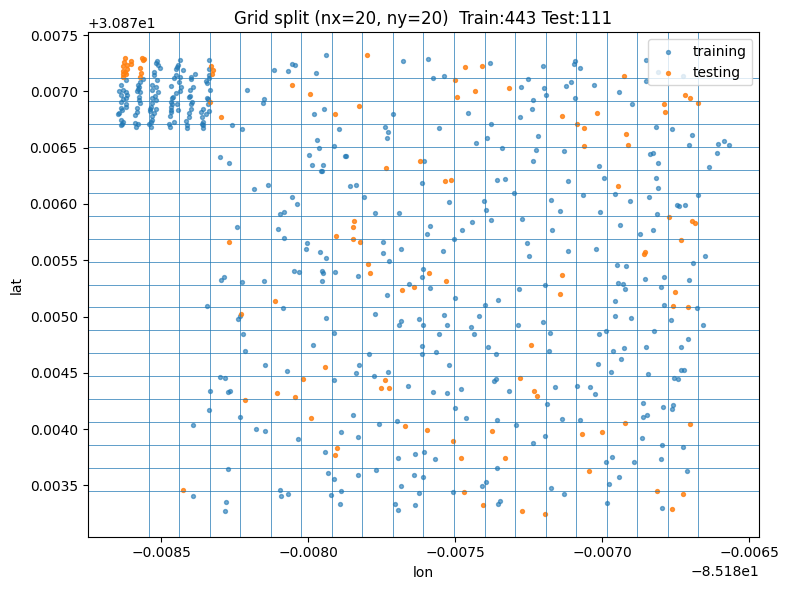

In [2]:
csv_path = '../all_data_two_date_gps_vi_savi_filter_0.9.csv'
output_prefix = './split_grid'
train_frac = 0.8
nx = 20
ny = 20
n_trials = 2000
random_state = 42
plot_result = True

random.seed(random_state)
np.random.seed(random_state)

df = pd.read_csv(csv_path)

if 'lon' not in df.columns or 'lat' not in df.columns:
    raise ValueError("CSV must contain 'lon' and 'lat' columns.")

total_count = len(df)
target_test_count = int(round((1 - train_frac) * total_count))

min_lon, max_lon = df['lon'].min(), df['lon'].max()
min_lat, max_lat = df['lat'].min(), df['lat'].max()

cell_size_lon = (max_lon - min_lon) / nx
cell_size_lat = (max_lat - min_lat) / ny

def lon_to_gx(lon):
    idx = int(math.floor((lon - min_lon) / cell_size_lon))
    if idx == nx: idx = nx - 1
    return idx

def lat_to_gy(lat):
    idx = int(math.floor((lat - min_lat) / cell_size_lat))
    if idx == ny: idx = ny - 1
    return idx

grid_ids = []
gx_list = []
gy_list = []
for _, row in df[['lon','lat']].iterrows():
    gx = lon_to_gx(row['lon'])
    gy = lat_to_gy(row['lat'])
    grid_ids.append(f"gx_{gx}_gy_{gy}")
    gx_list.append(gx)
    gy_list.append(gy)

df = df.copy()
df['grid_id'] = grid_ids
df['gx'] = gx_list
df['gy'] = gy_list

grid_counts = df.groupby('grid_id').size().to_dict()
grids = list(grid_counts.keys())

best_selection = None
best_diff = total_count
best_test_count = None

for t in range(n_trials):
    perm = grids.copy()
    random.shuffle(perm)
    sel = []
    cum = 0
    for g in perm:
        if cum >= target_test_count:
            break
        sel.append(g)
        cum += grid_counts[g]
    if sel:
        cum_minus_last = cum - grid_counts[sel[-1]]
        diff_minus = abs(cum_minus_last - target_test_count)
        diff = abs(cum - target_test_count)
        if diff_minus < diff:
            cum = cum_minus_last
            sel.pop()
            diff = diff_minus
        else:
            diff = abs(cum - target_test_count)
    else:
        diff = abs(cum - target_test_count)
    if diff < best_diff:
        best_diff = diff
        best_selection = set(sel)
        best_test_count = cum
    if best_diff == 0:
        break

if best_selection is None:
    best_selection = set()

df['folder'] = df['grid_id'].apply(lambda g: 'testing' if g in best_selection else 'training')

train_count = (df['folder']=='training').sum()
test_count = (df['folder']=='testing').sum()

output_path = output_prefix + '_best.csv'
df.to_csv(output_path, index=False)

if plot_result:
    try:
        plt.figure(figsize=(8,6))
        mask_train = df['folder']=='training'
        mask_test = df['folder']=='testing'
        plt.scatter(df.loc[mask_train,'lon'], df.loc[mask_train,'lat'], s=8, label='training', alpha=0.6)
        plt.scatter(df.loc[mask_test,'lon'], df.loc[mask_test,'lat'], s=8, label='testing', alpha=0.8)
        for i in range(1, nx):
            plt.axvline(min_lon + i*cell_size_lon, linewidth=0.5)
        for j in range(1, ny):
            plt.axhline(min_lat + j*cell_size_lat, linewidth=0.5)
        plt.legend()
        plt.xlabel('lon')
        plt.ylabel('lat')
        plt.title(f'Grid split (nx={nx}, ny={ny})  Train:{train_count} Test:{test_count}')
        plt.tight_layout()
        plt.show()
    except Exception:
        pass
